In [7]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import style

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import entropy
from scipy.stats import ks_2samp

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/sweep_full_real'
fnames = sorted(os.listdir(out_dir))
weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if fname.startswith('weights') and 
                'mnist' in fname and
                'numlays=4' in fname and 
                'batchsize=100' in fname]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()
# results.head()
# results_weights.dtypes

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 1500/1500 [00:02<00:00, 537.32it/s]

loaded 92 runs


# set the params

In [10]:
row = 0
epoch = 151
lay = 'fc.0.weight'
num_to_plot = 225

# derivatives
run = results_weights.iloc[row]

# cast variables to correct vals
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])

### plot weights

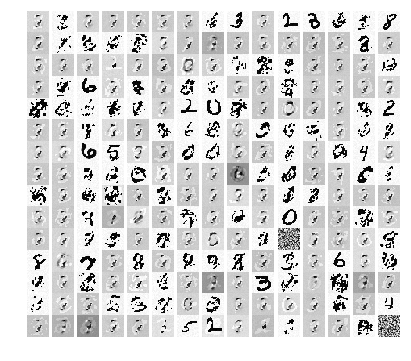

In [12]:
# keys are epochs, vals are dicts of all weights
weights_dict_dict = run['weights']

# keys are layers, vals are weight values
weights_dict = weights_dict_dict[epoch]

# matrix of weights (output x input)
w = weights_dict[lay]

viz_weights.plot_weights(w[:num_to_plot])
plt.show()

### reload the model

In [18]:
from vision_fit import data

# load model
train_loader, test_loader, model = data.get_data_and_model(run)

# load in weights
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items() if k in weights_dict}
model.load_state_dict(weights_dict_tensors)